# Application of UHN Associative Memory in PCGTAW
* Dataset obtained from Pal S.K. (2007) Artificial Neural Network modelling of weld joint strength prediction of a pulsed metal inert gas welding process using arc signals

#### 01- Import and clean the dataset

In [13]:
import pandas as pd
import numpy as np
import UHN as UHN
import matplotlib.pyplot as plt
import seaborn as sns

data = open("Pal S.K. 2007 Data set.csv")
data = pd.read_csv(data)
data.head()

# We do not wish to store experiment no.
data_clean = data.drop(["Experiment no."], axis = 1)
display(data_clean.head())

train_data = data_clean.to_numpy()
np.set_printoptions(precision = 4, suppress = True, threshold = np.inf, linewidth = np.inf)

,Back-ground voltage (V),Pulse voltage (V),Pulse frequency (Hz),Pulse duty factor,Wire feed rate (m/min),table feed rate (mm/s),RMS current (V),RMS voltage (V),UTS (Mpa)
0,17,34.6,130,0.50,9,3.760,1.1939,2.7429,412.28
1,17,34.6,130,0.50,9,3.760,1.1415,2.7449,415.79
2,14,30.0,80,0.35,11,5.635,1.4385,1.6834,0.00
3,14,39.0,80,0.35,7,5.635,1.1971,2.7190,328.71
4,14,30.0,182,0.65,11,5.635,1.2566,2.3814,385.98


#### 02 - Exploratory Analysis

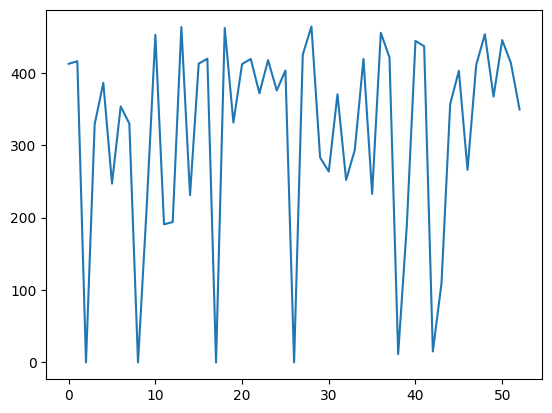

Back-ground voltage (V)
Back-ground voltage (V)
17    19
14    17
20    17
Name: count, dtype: int64


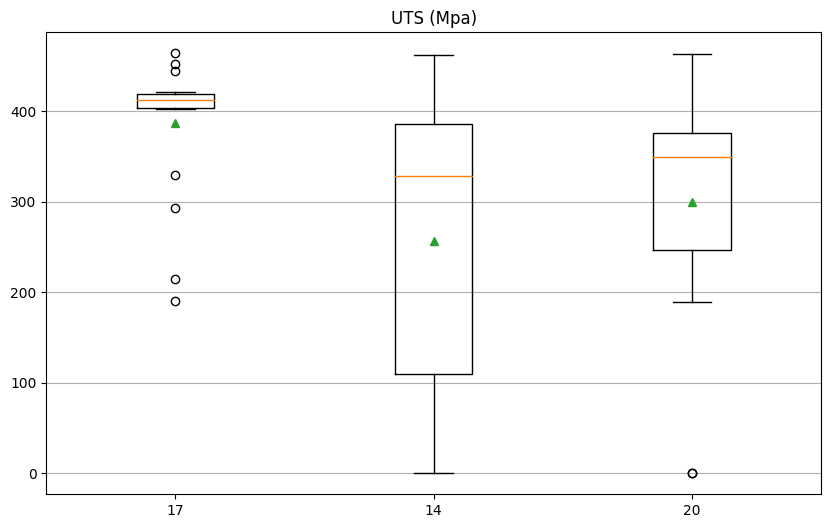

Pulse voltage (V)
Pulse voltage (V)
34.6    19
30.0    17
39.0    17
Name: count, dtype: int64


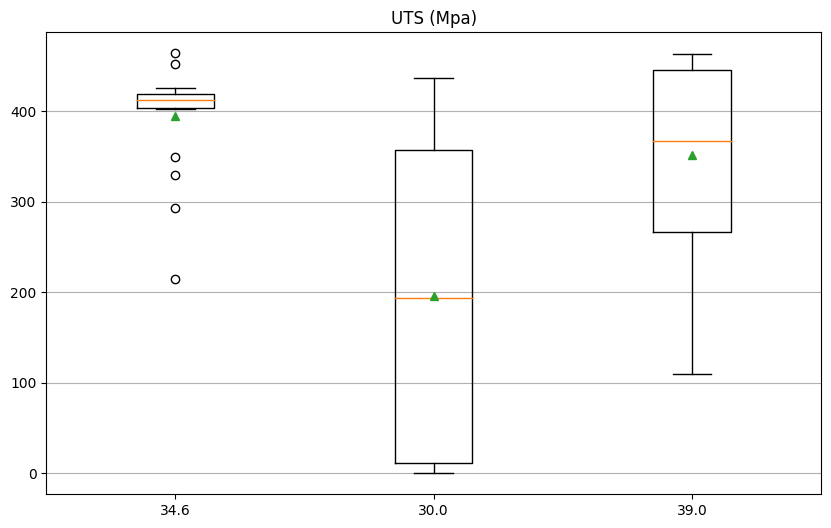

Pulse frequency (Hz)
Pulse frequency (Hz)
130    19
80     17
182    17
Name: count, dtype: int64


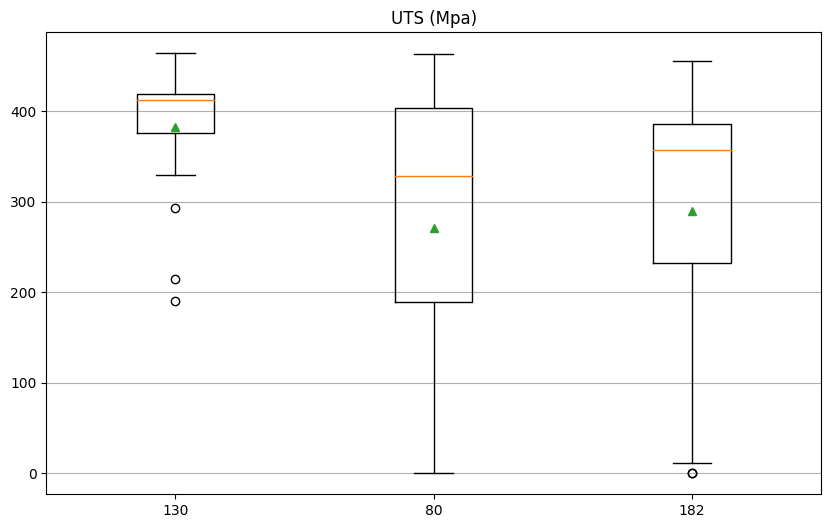

Pulse duty factor
Pulse duty factor
0.50    19
0.35    17
0.65    17
Name: count, dtype: int64


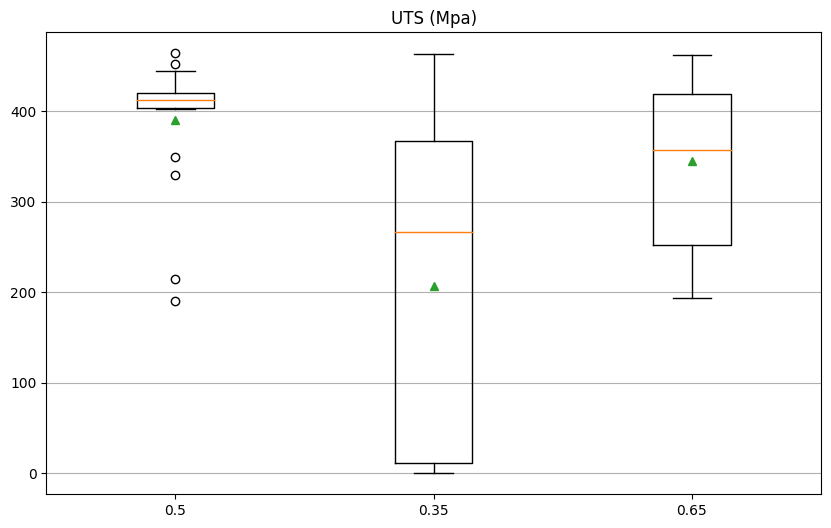

Wire feed rate (m/min)
Wire feed rate (m/min)
9     19
11    17
7     17
Name: count, dtype: int64


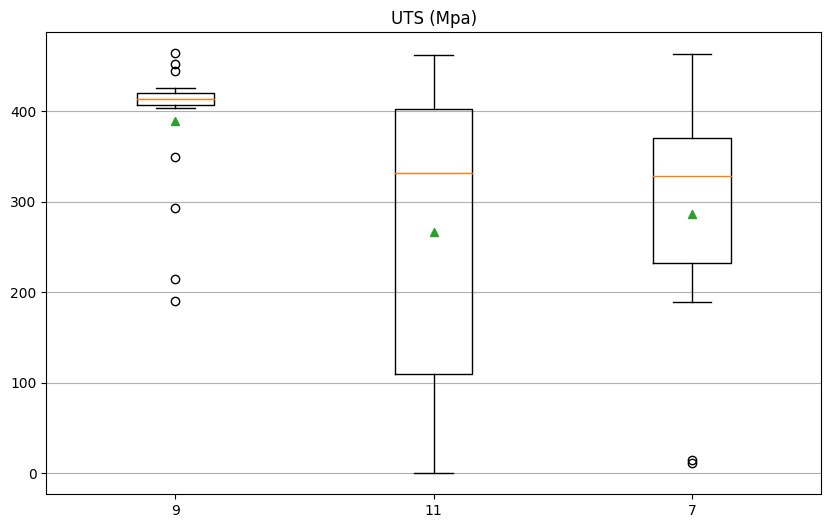

table feed rate (mm/s)
table feed rate (mm/s)
3.760    19
5.635    17
2.456    17
Name: count, dtype: int64


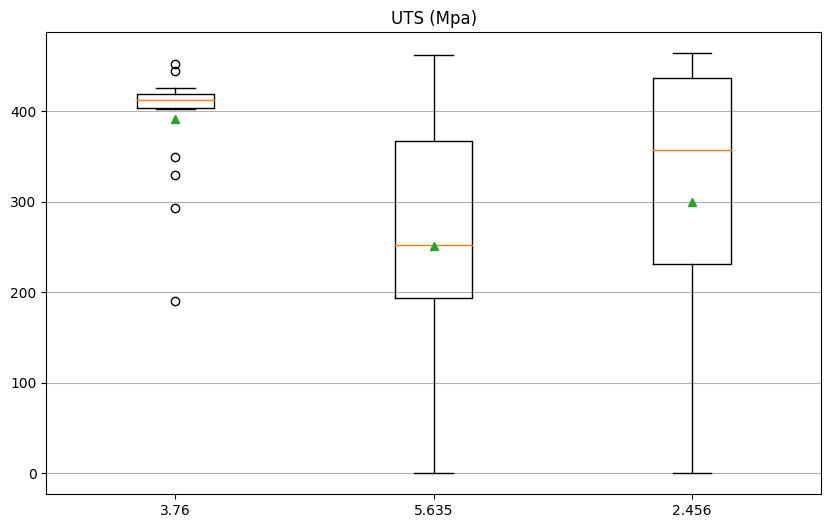

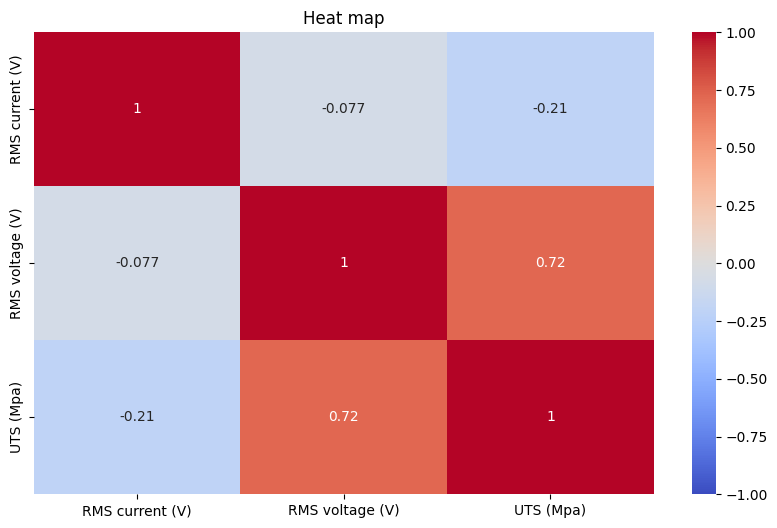

RMS current (V)


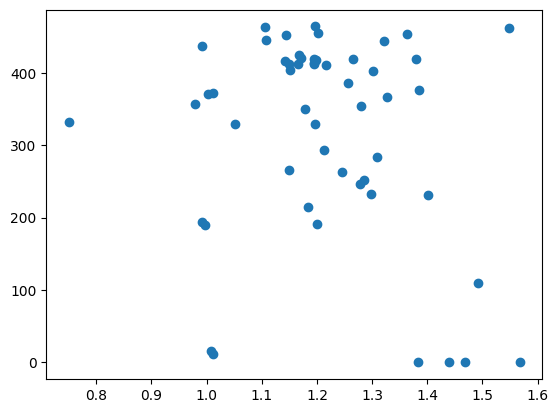

RMS voltage (V)


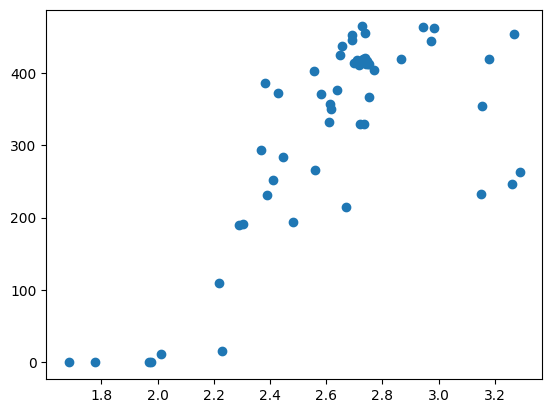

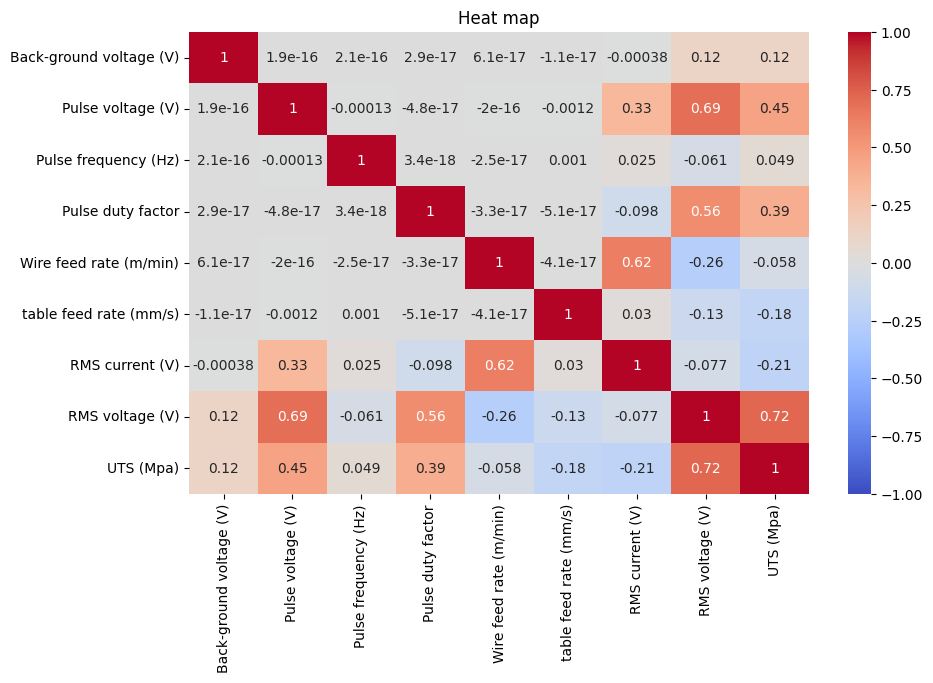

In [2]:
def decomposed_box(df, main_series, set_of_series, width = 10, height = 6, rotation = None):
    """
    Generates a box plot of each series in the set_of_series but each series' box plot is 
    seperated into multiple box plots corresponding to different categories in the main series 
    """
    # Determine the unique categories in the main series
    break_down = df[main_series].value_counts()
    print(break_down)
    cats = break_down.index.tolist()

    # For each set of series, create a list of series categorised based on the main series
    source_data = []
    for series in set_of_series:
        data = []
        for cat in cats:
            data.append(df.loc[df[main_series] == cat][series])
        source_data.append(data)
    
    # source_data now contains a list for each of the series in set_of_series
    # each list has a list containing the data for each category
    # Now plot the box plot for each category and each series

    i = 0
    for series in source_data:
        box(series, df = df, width = width, height = height, grid = True, series = True, together = True, vert = True, labels = cats, title = set_of_series[i], rotation = rotation)
        plt.show()
        i += 1

def box(vars, df = None, width = 4, height = 8, vert = False, together = False, grid = False, series = False, labels = None, title = None, rotation = None):
    """
    Generates a box plot of a sequence of variables vars of a dataframe df
    """
    
    # if series is True then vars is a list of pandas series else it is a list of column names
    if series == True:
        # Store label names of all pandas series if labels don't exist
        if labels == None:
            labels = []
            for col in vars:
                labels.append(col.name)

        # Plot the box plot of all series with appropriate labels
        plt.figure(figsize = (width, height))
        plt.boxplot(vars, vert = vert, labels = labels, showmeans = True)
        plt.grid(grid, axis = "y")

        if title != None:
            plt.title(title)

        if rotation != None:
            plt.xticks(labels, labels, rotation = rotation)
        
        plt.show()
        return 

def heat(df, width = 10, height = 6):
    """
    Generates a heat map of a dataframe of quantitative variables (var_list)
    """
    # Generate correlation matrix
    corr_matrix = df.corr()

    plt.figure(figsize = (width, height))
    sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", vmin = -1, vmax = 1)
    plt.title(f"""Heat map""")
    plt.show()

plt.plot(data_clean["UTS (Mpa)"])
plt.show()

for val in ["Back-ground voltage (V)", "Pulse voltage (V)", "Pulse frequency (Hz)", "Pulse duty factor", "Wire feed rate (m/min)", "table feed rate (mm/s)"]:
    print(val)
    decomposed_box(data_clean, val, ["UTS (Mpa)"])

heat(data_clean[["RMS current (V)", "RMS voltage (V)", "UTS (Mpa)"]])

for val in ["RMS current (V)", "RMS voltage (V)"]:
    print(val)
    plt.scatter(data_clean[val], data_clean["UTS (Mpa)"])
    plt.show()

heat(data_clean)

#### 03 - Testing various Separator and Similarity fuctions in recalling strength with zero masking

In [3]:
similarity_functions = [UHN.manhattan, UHN.euclidean]
separator_functions = [UHN.softmax, UHN.max, UHN.polynomial_2, UHN.polynomial_5, UHN.polynomial_10]

zero_mask_strength = {} # Stores the recalled patterns for zero masking strength
nan_mask_strength = {} # Stores the recalled patterns for nan masking strength

In [4]:

for separator in separator_functions:
    for similarity in similarity_functions:
        # Build and fit the model
        model = UHN.UHNModel(similarity= similarity, separator= separator, projection= UHN.weighted_sum, iterator = None, quiet= True)
        data_patterns = data_clean.to_numpy()
        model.fit(data_patterns)

        # Create a query dataset with the strength zero masked 
        zquery_data = data_clean.copy()
        zquery_data["UTS (Mpa)"] = 0
        zquery_data = zquery_data.to_numpy()

        # Query the model to get the recalled strength
        recalled_pattern = []
        for query in zquery_data:
            recalled_pattern.append(model.query(query))
        print(separator)
        zero_mask_strength[model.separator.type() + " " + model.similarity.type()] = recalled_pattern

<class 'UHN.softmax'>
<class 'UHN.softmax'>
<class 'UHN.max'>
<class 'UHN.max'>
<class 'UHN.polynomial_2'>
<class 'UHN.polynomial_2'>
<class 'UHN.polynomial_5'>
<class 'UHN.polynomial_5'>
<class 'UHN.polynomial_10'>
<class 'UHN.polynomial_10'>


c:\Users\user\Documents\Life\Learn\Data Science & AI\Universal Hopfield Networks\Application of UHN Models\Pulsed Current Gas Tungsten Arc Welding\UHN.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  similarity_matrix.append(1 / diff[np.logical_not(np.isnan(diff))].sum())
c:\Users\user\Documents\Life\Learn\Data Science & AI\Universal Hopfield Networks\Application of UHN Models\Pulsed Current Gas Tungsten Arc Welding\UHN.py:101: RuntimeWarning: divide by zero encountered in scalar divide
  similarity_matrix.append(1 / diff[np.logical_not(np.isnan(diff))].sum())


#### 04 - Testing various Separator and Similarity fuctions in recalling strength with Nan masking

In [5]:
for separator in separator_functions:
    for similarity in similarity_functions:
        # Build and fit the model
        model = UHN.UHNModel(similarity= similarity, separator= separator, projection= UHN.weighted_sum, iterator = None, quiet= True)
        data_patterns = data_clean.to_numpy()
        model.fit(data_patterns)

        # Create a query dataset with the strength zero masked 
        query_data = data_clean.copy()
        query_data["UTS (Mpa)"] = np.nan
        query_data = query_data.to_numpy()

        # Query the model to get the recalled strength
        recalled_pattern = []
        for query in query_data:
            recalled_pattern.append(model.query(query))
        print(separator)
        nan_mask_strength[model.separator.type() + " " + model.similarity.type()] = recalled_pattern

<class 'UHN.softmax'>
<class 'UHN.softmax'>
<class 'UHN.max'>
<class 'UHN.max'>
<class 'UHN.polynomial_2'>
<class 'UHN.polynomial_2'>
<class 'UHN.polynomial_5'>
<class 'UHN.polynomial_5'>
<class 'UHN.polynomial_10'>
<class 'UHN.polynomial_10'>


#### 05 - View perfomance of the zero masking, separator and similarities in Strength recall

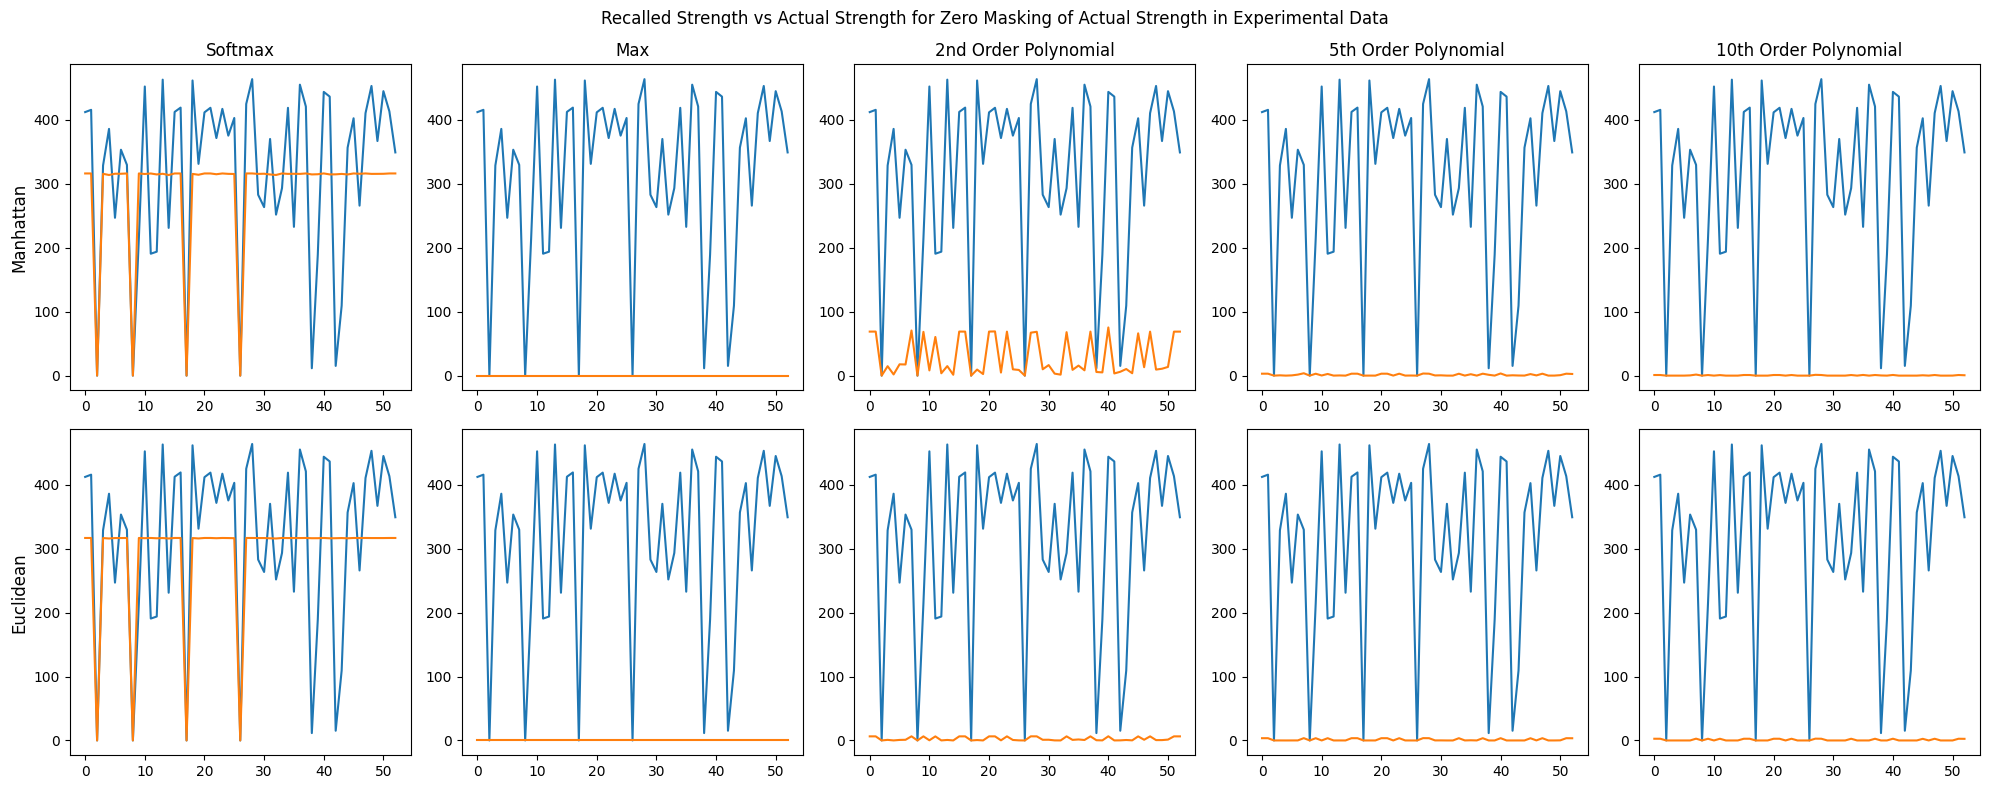

In [6]:
# Access the zero mask performance store and retrieve the the predicted strength vs actual strength. 
# Plot the predicted vs actual strength for each separator - similarity type in the store
title = "Zero Masking"

nrows = len(similarity_functions)
ncols = len(separator_functions)

fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize=(20, 8))

fig.suptitle("Recalled Strength vs Actual Strength for Zero Masking of Actual Strength in Experimental Data")

for ax, col in zip(axes[0], separator_functions):
    ax.set_title(col().type())

for ax, row in zip(axes[:,0], similarity_functions):
    ax.set_ylabel(row().type(), size='large')

for i in range(nrows):
    for j in range(ncols):
        similarity_type = similarity_functions[i]
        separator_type = separator_functions[j]

        data = pd.DataFrame(zero_mask_strength[separator_type().type() + " " + similarity_type().type()], 
        columns = ['Back-ground voltage (V)', 'Pulse voltage (V)', 'Pulse frequency (Hz)','Pulse duty factor', 
        'Wire feed rate (m/min)', 'table feed rate (mm/s)','RMS current (V)', 'RMS voltage (V)', 'Recalled UTS (Mpa)'])
        
        axes[i, j].plot(data_clean["UTS (Mpa)"], label = "Actual")
        axes[i, j].plot(data['Recalled UTS (Mpa)'], label = "Recalled")

fig.tight_layout()
plt.show()

#### 06 - View perfomance of the Nan masking, separator and similarities in strength recall

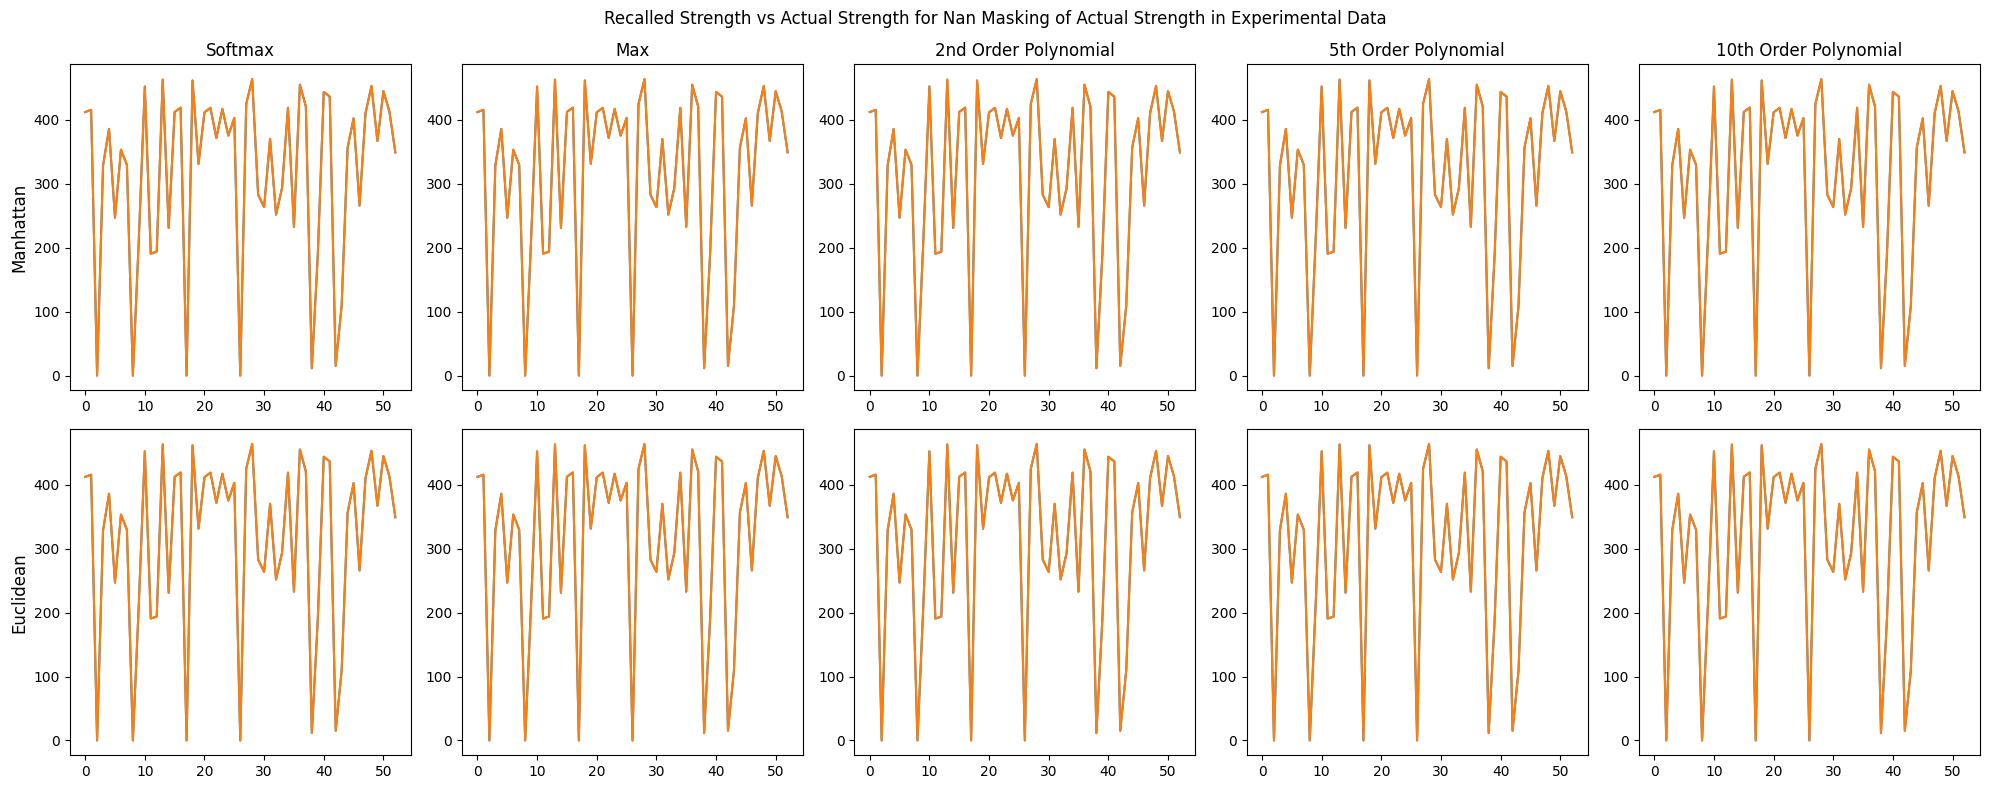

In [7]:
# Access the Nan mask performance store and retrieve the the predicted strength vs actual strength. 
# Plot the predicted vs actual strength for each separator - similarity type in the store
title = "Zero Masking"

nrows = len(similarity_functions)
ncols = len(separator_functions)

fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize=(20, 8))

fig.suptitle("Recalled Strength vs Actual Strength for Nan Masking of Actual Strength in Experimental Data")

for ax, col in zip(axes[0], separator_functions):
    ax.set_title(col().type())

for ax, row in zip(axes[:,0], similarity_functions):
    ax.set_ylabel(row().type(), size='large')

for i in range(nrows):
    for j in range(ncols):
        similarity_type = similarity_functions[i]
        separator_type = separator_functions[j]
        data = pd.DataFrame(nan_mask_strength[separator_type().type() + " " + similarity_type().type()], 
        columns = ['Back-ground voltage (V)', 'Pulse voltage (V)', 'Pulse frequency (Hz)','Pulse duty factor', 
        'Wire feed rate (m/min)', 'table feed rate (mm/s)','RMS current (V)', 'RMS voltage (V)', 'Recalled UTS (Mpa)'])
        axes[i, j].plot(data_clean["UTS (Mpa)"], label = "Actual")
        axes[i, j].plot(data['Recalled UTS (Mpa)'], label = "Recalled")

fig.tight_layout()
plt.show()

#### 07 - Test generalization of Associative Models as Prediction models

In [8]:
train_frac = np.linspace(0.05, 0.95, 38)

model_performance = {}

indexes = [0]
for i in range(len(train_data) - 1):
    indexes.append(indexes[-1] + 1)

for similarity in similarity_functions:
    for separator in separator_functions:

        avg_errors = []
        std_of_errors = []
        test = []

        for frac in train_frac:
                
            errors = []

            for n in range(100):

                # randomly select {frac} of the total number of data patterns to store in the current model
                data_to_store_indexes = np.random.choice(indexes, size = int(frac * len(train_data)), replace = False)
                data_to_store = train_data[data_to_store_indexes]
                data_to_test_with = np.delete(train_data.copy(), data_to_store_indexes, axis = 0)

                # store the data in the associative model
                model = UHN.UHNModel(similarity = similarity, separator = separator, projection = UHN.weighted_sum)
                model.fit(data_to_store)

                # use the model to predict the strength in the total number of data patterns not stored using Nan masking
                actual_strengths = np.transpose(data_to_test_with)[len(train_data[0]) - 1]
                predicted_strengths = []
                query_data = data_to_test_with.copy()
                for query in query_data:
                    query[len(query) - 1] = np.nan
                    strength = model.query(query)[len(query) - 1]
                    predicted_strengths.append(strength)

                # calculate and store the mse of the prediction
                errors.append((predicted_strengths - actual_strengths) ** 2)
            
            errors = np.array(errors)
            # calculate the mean and standard deviation of the mse
            avg_errors.append(np.average(errors))
            std_of_errors.append(np.std(errors))
            test.append(1)

        # add mse and std to data of the frac for the model
        model_performance[similarity().type() + " " + separator().type()] = [avg_errors, std_of_errors]

c:\Users\user\Documents\Life\Learn\Data Science & AI\Universal Hopfield Networks\Application of UHN Models\Pulsed Current Gas Tungsten Arc Welding\UHN.py:131: RuntimeWarning: overflow encountered in power
  exponents = self.exponent ** similarity_matrix
c:\Users\user\Documents\Life\Learn\Data Science & AI\Universal Hopfield Networks\Application of UHN Models\Pulsed Current Gas Tungsten Arc Welding\UHN.py:132: RuntimeWarning: invalid value encountered in divide
  probabilities = ((exponents) / exponents.sum())


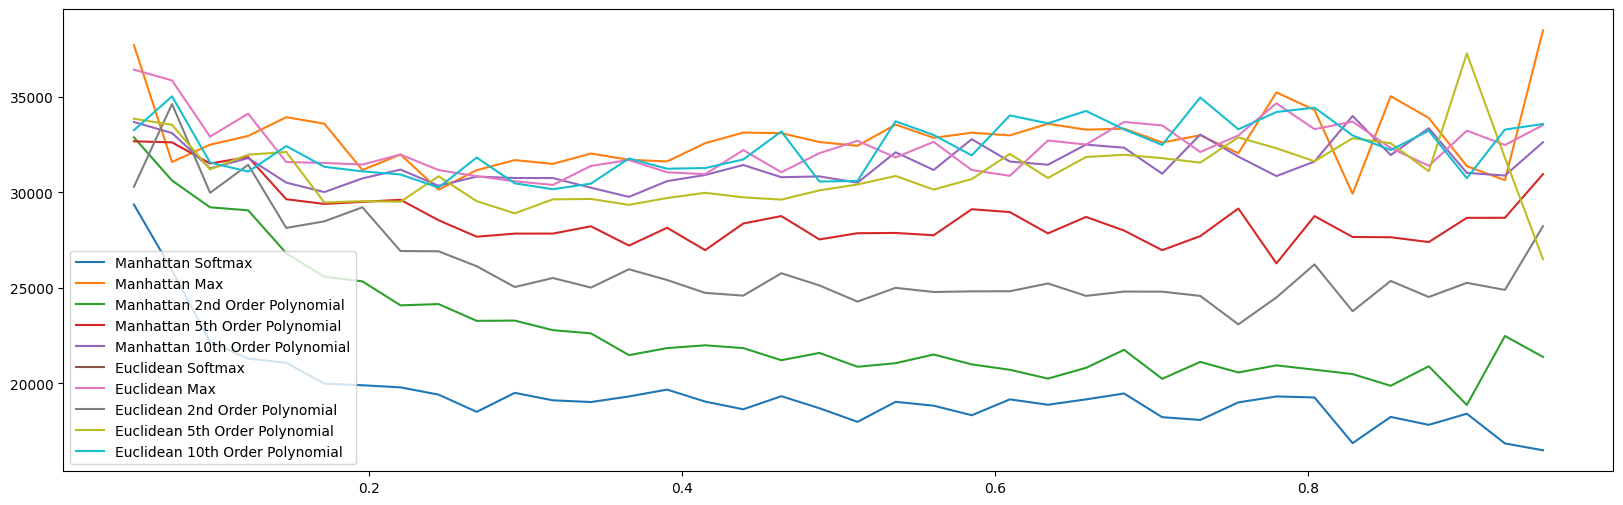

In [9]:

plt.figure(figsize = (20, 6))

for similarity in similarity_functions:
    for separator in separator_functions:
        
        key = similarity().type() + " " + separator().type()
        avg, std = model_performance[key]
        plt.plot(train_frac, avg, label = key)

plt.legend()
plt.show()

* Best performing is the Manhattan Softmax for prediction
* average MSE error is very high which is expected from a small dataset, there isn't eneough data patterns to learn from which the model can interpolate accurately as in an interpolative associative memory
* due to the inaccuracy of predictions, sensitivity analysis cannot be conducted

#### 08 - Prediction of Process Parameters for a desired Weld Strength

In [62]:
# Blank out the process parameters as query data leaving only strength
df = data_clean.copy()
for column in data_clean.columns:
    df[column] = np.nan
df["UTS (Mpa)"] = data_clean["UTS (Mpa)"]
query_data = df.to_numpy()

actual = data_clean.to_numpy() # store actual data
# define function to measure the average percentage deviation of each parameter of a vector from it's original
def no_nan_mean(list):
    ssum = 0
    for val in list:
        if not ((np.isnan(val)) or (np.isinf(val))):
            ssum += val
    return ssum/len(list)

def deviation(actual, predicted):
    for i in range(len(actual)):
        if abs(round(actual[i] - predicted[i], 4)) != 0:
            diff = abs(actual - predicted)
            relative_diff = diff / actual
            return no_nan_mean(relative_diff) * 100
        else:
            continue
    return 0

# query the different models
prediction_performance = {}
prediction_deviation = {}
for separator in separator_functions:
    for similarity in similarity_functions:
        model = UHN.UHNModel(separator = separator, similarity = similarity, projection = UHN.weighted_sum)
        model.fit(train_data)
        prediction = []
        for query in query_data:
            prediction.append(model.query(query))
        prediction_performance[similarity().name + " " + separator().name] = prediction

        # measure the average percentage deviation of each parameter from it's original for each model
        deviations = []
        for i in range(len(actual)):
            dev = deviation(np.array(actual[i]), np.array(prediction[i]))
            if dev == np.inf or dev == np.nan:
                print(actual[i])
                print(prediction[i])
            deviations.append(dev)
        prediction_deviation[similarity().name + " " + separator().name] = np.mean(np.array(deviations))

        # actual data intiated above


# do the same above on a fractional basis

c:\Users\user\Documents\Life\Learn\Data Science & AI\Universal Hopfield Networks\Application of UHN Models\Pulsed Current Gas Tungsten Arc Welding\UHN.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  similarity_matrix.append(1 / diff[np.logical_not(np.isnan(diff))].sum())
C:\Users\user\AppData\Local\Temp\ipykernel_11948\311903149.py:21: RuntimeWarning: divide by zero encountered in divide
  relative_diff = diff / actual
c:\Users\user\Documents\Life\Learn\Data Science & AI\Universal Hopfield Networks\Application of UHN Models\Pulsed Current Gas Tungsten Arc Welding\UHN.py:101: RuntimeWarning: divide by zero encountered in scalar divide
  similarity_matrix.append(1 / diff[np.logical_not(np.isnan(diff))].sum())
C:\Users\user\AppData\Local\Temp\ipykernel_11948\311903149.py:21: RuntimeWarning: invalid value encountered in divide
  relative_diff = diff / actual


#### 09 - Correction of Erroneous Process Parameters for a Desired Weld Strength

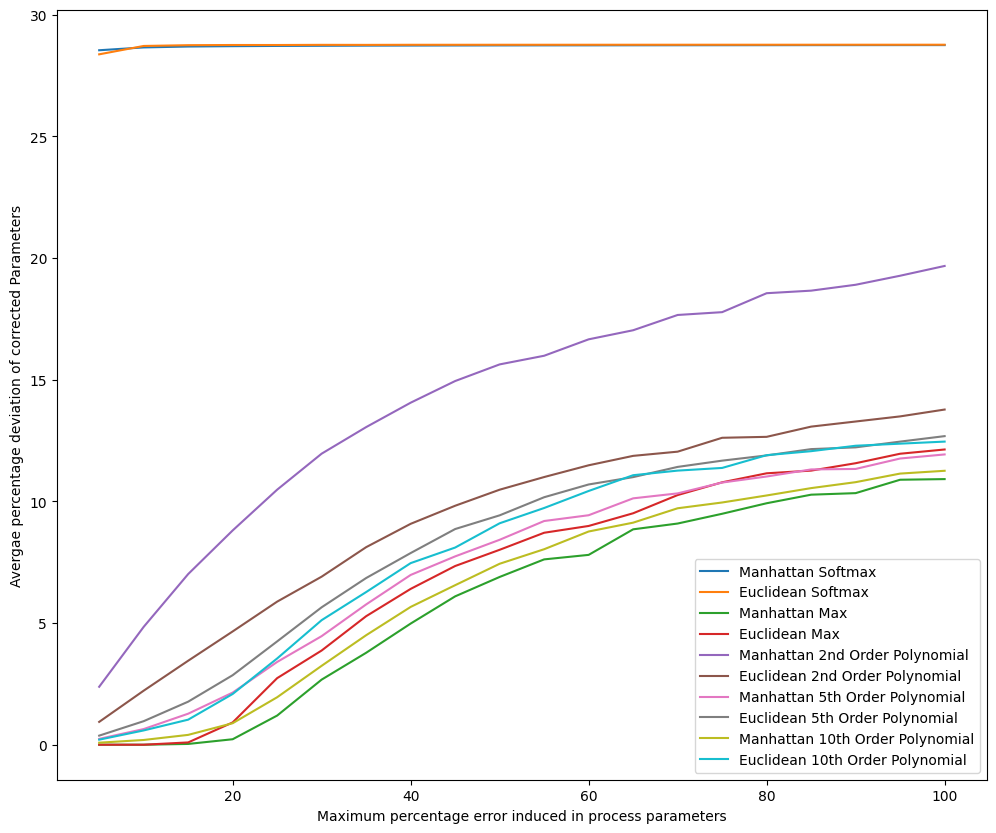

In [132]:
similarity_functions = [UHN.manhattan, UHN.euclidean]
separator_functions = [UHN.softmax, UHN.max, UHN.polynomial_2, UHN.polynomial_5, UHN.polynomial_10]

# Generate the list of deviations
deviations = np.linspace(5, 100, 20)

# Create query data
actual_data = data_clean[data_clean["UTS (Mpa)"] != 0].to_numpy()

# Create a function to deviate all process parameters by a maximum deviation percentage
# while keeping the desired strength the same
def deviate (actual, dev):
    query = []
    for i in range(len(actual) - 1):
        query.append(actual[i] * (1 + (np.random.randint(-1 * dev, dev + 1) / 100)))
    query.append(actual[-1])
    return query

# define function to measure the average percentage deviation of each parameter of a vector from it's original
def no_nan_mean(list):
    ssum = 0
    for val in list:
        if not ((np.isnan(val)) or (np.isinf(val))):
            ssum += val
        else: print("saw nana")
    return ssum/len(list)

def deviation(actual, predicted):
    for i in range(len(actual)):
        if abs(round(actual[i] - predicted[i], 4)) != 0:
            diff = abs(actual - predicted)
            relative_diff = diff / actual
            return no_nan_mean(relative_diff) * 100
        else:
            continue
    return 0

model_performance = {}
plt.figure(figsize = (12, 10))

trials = 100

for separator in separator_functions:
    for similarity in similarity_functions:
        model = UHN.UHNModel(similarity = similarity, separator = separator, projection = UHN.weighted_sum)
        model.fit(actual_data)
        key = similarity().name + " " + separator().name
        model_performance[key] = []
        for dev in deviations:
            percentage_deviations = []
            for tial in range(trials):
                for actual in actual_data:
                    query = actual.copy()
                    query = deviate(query, dev)
                    correction = model.query(np.array(query))
                    ans = deviation(actual, correction)
                    percentage_deviations.append(ans)
            model_performance[key].append(no_nan_mean(percentage_deviations))

        plt.plot(deviations, model_performance[key], label = key)

plt.legend()
plt.xlabel("Maximum percentage error induced in process parameters")
plt.ylabel("Avergae percentage deviation of corrected Parameters")
plt.show()

In [125]:
a  = model_performance[key]
print(len(a))

980


In [ ]:
np.random.rand